In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from get_all_tickers import get_tickers as gt
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
def get_data(stock_name):
    # get all major data to the project
    big_data = yf.Ticker(stock_name)
    start_date = '1990-01-01'
    end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

    stock = big_data.history(start=start_date, end=end_date).copy()

    # Transforming the data to analysis
    stock.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
    stock['Lag_1'] = stock[["Close"]].shift(1)
    stock['Target'] = (stock['Lag_1'] > stock['Close']).astype('int')
    return stock
stock = get_data("GGBR4.SA")
stock.head()

## Step 2: Do a machine learning algorith

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test["Target"],preds)

0.7111111111111111

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

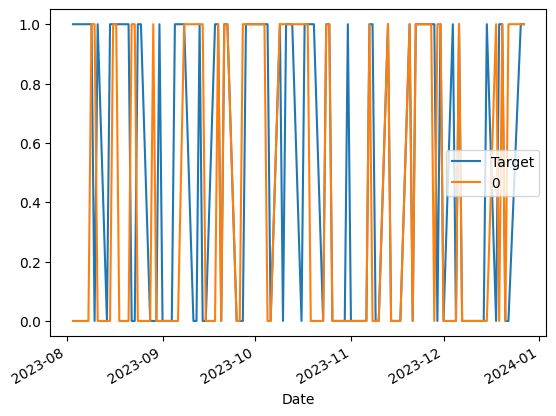

In [ ]:
# Show the result of predictions
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data,model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(stock, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

Predictions
0    2129
1    1396
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7027220630372493